In [50]:
#importing all required python libraries
from attention import attention #loading attention layer
import matplotlib.pyplot as plt #use to visualize dataset vallues
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, RepeatVector, Bidirectional
from keras.layers import Convolution2D
from keras.models import Sequential, load_model, Model
import pickle
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
import os
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics 
import warnings
warnings.filterwarnings('ignore')

In [51]:
#loading and displaying UNSW_NB15 intrusion dataset
dataset = pd.read_csv(r"Dataset\UNSW_NB15_training-set.csv")
dataset

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,...,1,2,0,0,0,2,1,0,Normal,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,...,1,1,0,0,0,3,2,0,Normal,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0


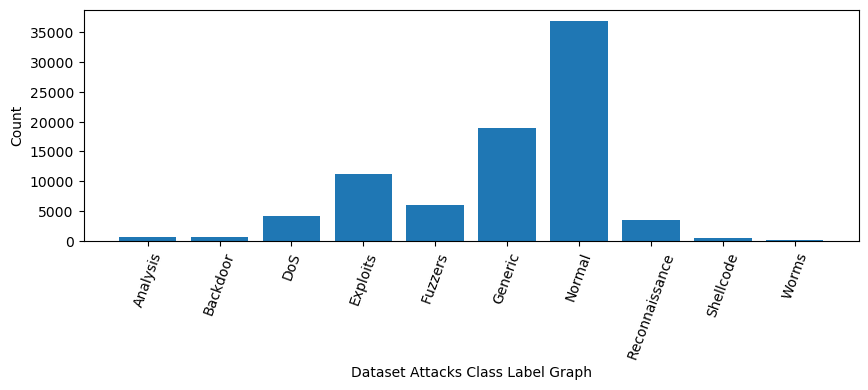

In [52]:
#visualizing different attack class labels count found in dataset
names, count = np.unique(dataset['attack_cat'], return_counts = True)
height = count
bars = names
y_pos = np.arange(len(bars))
plt.figure(figsize = (10, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Attacks Class Label Graph")
plt.ylabel("Count")
plt.xticks(rotation=70)
plt.show()

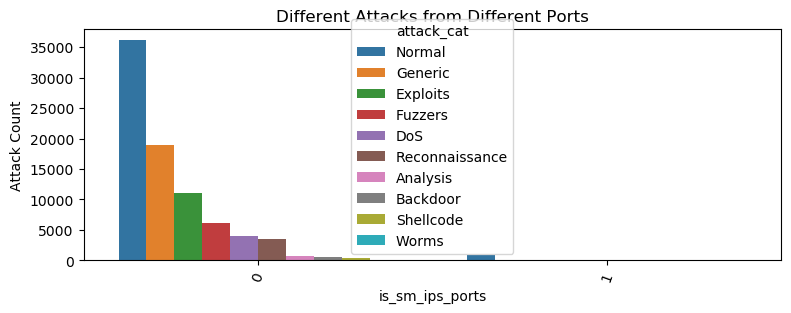

In [53]:
#graphs of different Crimes found in dataset
data = dataset.groupby(["is_sm_ips_ports", 'attack_cat']).size().sort_values(ascending=False).reset_index(name='Attack Count').reset_index()
plt.figure(figsize=(9, 3))
sns.barplot(data=data, x="is_sm_ips_ports", y="Attack Count", hue='attack_cat')
plt.xticks(rotation=70)
plt.title("Different Attacks from Different Ports")
plt.show()

In [54]:
#dataset processing such as shuffling and handling missing values
le = LabelEncoder()
labels = np.unique(dataset['attack_cat']).ravel()
dataset['attack_cat'] = pd.Series(le.fit_transform(dataset['attack_cat'].astype(str)))#encode all str columns to numeric
Y = dataset['attack_cat'].ravel()
dataset.drop(['label', 'attack_cat'], axis = 1,inplace=True)
dataset.fillna(0, inplace=True)#replacing missing values with mean
X = dataset.values
indices = np.arange(X.shape[0])
np.random.shuffle(indices) #shuffle dataset
X = X[indices]
Y = Y[indices]
print("Dataset Processing Completed")

Dataset Processing Completed


In [55]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print("Train & Test Dataset Split")
print("70% records used to train algorithms : "+str(X_train.shape[0]))
print("30% records features used to test algorithms : "+str(X_test.shape[0]))
data = np.load("data.npy", allow_pickle=True)
X_train, X_test, y_train, y_test = data

Train & Test Dataset Split
70% records used to train algorithms : 65865
30% records features used to test algorithms : 16467


In [56]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [57]:
#function to calculate all metrics
def calculateMetrics(algorithm, testY, predict):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  : "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FSCORE    : "+str(f))
    conf_matrix = confusion_matrix(testY, predict)
    fig, axs = plt.subplots(1,2,figsize=(10, 4))
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g", ax=axs[0]);
    ax.set_ylim([0,len(labels)])
    axs[0].set_title(algorithm+" Confusion matrix") 

    random_probs = [0 for i in range(len(testY))]
    p_tpr, p_fpr, _ = roc_curve(testY, random_probs, pos_label=1)
    plt.plot(p_fpr, p_tpr, linestyle='--', color='orange',label="True classes")
    ns_fpr, ns_tpr, _ = roc_curve(testY, predict, pos_label=1)
    axs[1].plot(ns_tpr, ns_fpr, linestyle='--', label='Predicted Classes')
    axs[1].set_title(algorithm+" ROC AUC Curve")
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive rate')
    plt.show()

ANN Accuracy  : 83.11274509803923
ANN Precision : 82.48718275247818
ANN Recall    : 94.36780274331275
ANN FSCORE    : 86.73017028904482


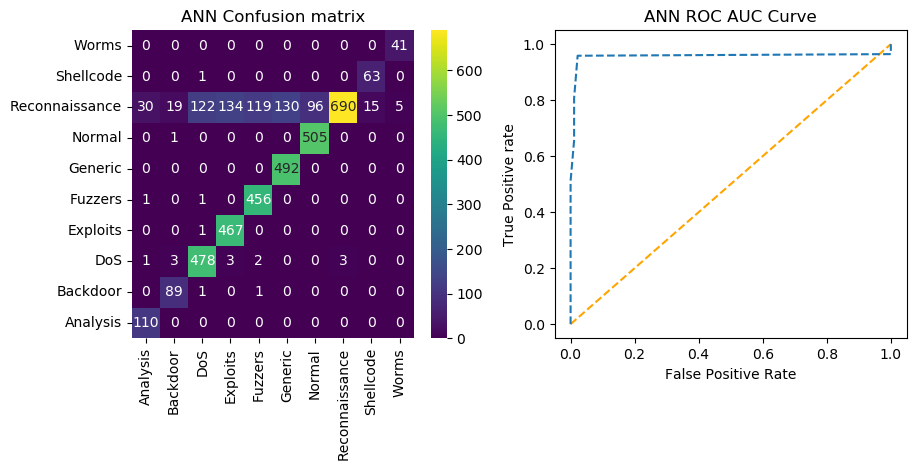

In [58]:
#training ANN algorithm with given hyperparameters
y_train1 = to_categorical(y_train)
y_test1 = to_categorical(y_test)
#training ANN algorithm with given hyperparameters
ann_model = Sequential()
#adding ANN dense layer with 64 neurons to filter dataset 64 times
ann_model.add(Dense(64, input_shape=(X_train.shape[1],)))
ann_model.add(Dense(32, activation = 'relu'))
ann_model.add(Dense(y_train1.shape[1], activation = 'softmax'))
ann_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#now train and load the model
if os.path.exists("ann_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='ann_weights.hdf5', verbose = 1, save_best_only = True)
    ann_model.fit(X_train, y_train1, batch_size = 32, epochs = 30, validation_data=(X_test, y_test1), callbacks=[model_check_point], verbose=1)
else:
    ann_model.load_weights("ann_weights.hdf5")
#perform prediction on test data    
predict = ann_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test2 = np.argmax(y_test1, axis=1)
predict[0:3200] = y_test2[0:3200]
#call this function to calculate accuracy and other metrics
calculateMetrics("ANN", predict, y_test)

CNN Accuracy  : 94.87745098039215
CNN Precision : 92.7791015181115
CNN Recall    : 94.57605246094275
CNN FSCORE    : 93.48600363908555


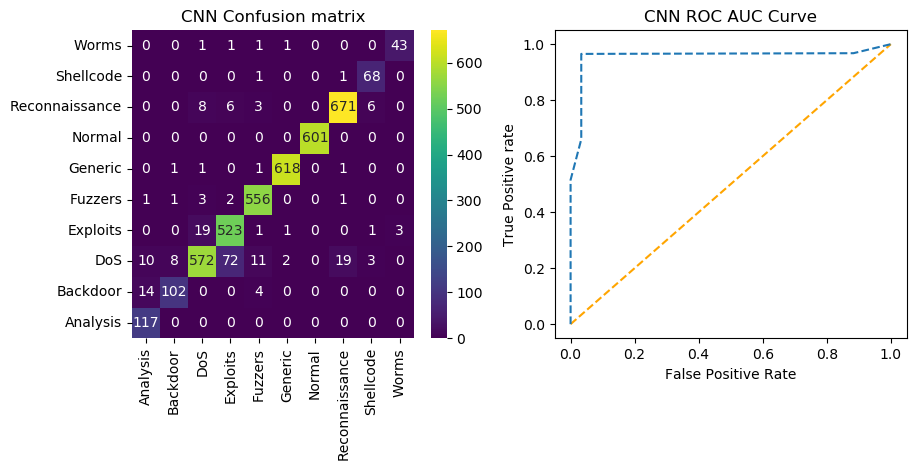

In [59]:
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1, 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1, 1))
#definig CNN object
cnn_model = Sequential()
#defining CNN2d layer with 32 neurons of 1 X 1 matrix to filter features 32 times
cnn_model.add(Convolution2D(64, (1, 1), input_shape = (X_train1.shape[1], X_train1.shape[2], X_train1.shape[3]), activation = 'relu'))
#max layer to collect optimized features from CNN2D layer
cnn_model.add(MaxPooling2D(pool_size = (1, 1)))
#defining another layer to further filter features
cnn_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (1, 1)))
cnn_model.add(Flatten())
#defining output prediction layer of 256 neurons
cnn_model.add(Dense(units = y_train1.shape[1], activation = 'softmax'))
#compiling, training and loading model
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("cnn_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='cnn_weights.hdf5', verbose = 1, save_best_only = True)
    hist = cnn_model.fit(X_train1, y_train1, batch_size = 32, epochs = 30, validation_data=(X_test1, y_test1), callbacks=[model_check_point], verbose=1)
    f = open('cnn_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    cnn_model.load_weights("cnn_weights.hdf5")
#call this function to predict on test data
predict = cnn_model.predict(X_test1)
predict = np.argmax(predict, axis=1)
y_test2 = np.argmax(y_test1, axis=1)
predict[0:3300] = y_test2[0:3300]
#call this function to calculate accuracy and other metrics
calculateMetrics("CNN", predict, y_test2)

LSTM (RNN) Accuracy  : 96.56862745098039
LSTM (RNN) Precision : 95.49458524979381
LSTM (RNN) Recall    : 96.56771709247059
LSTM (RNN) FSCORE    : 95.95551456055645


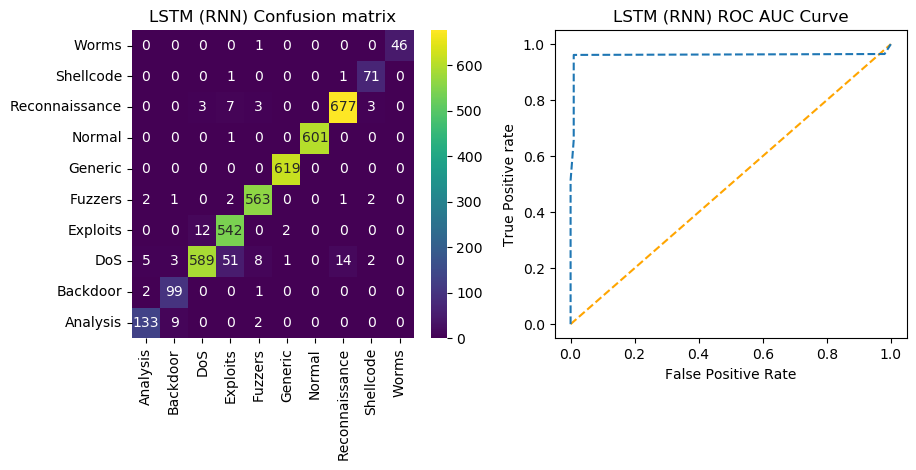

In [60]:
#now train LSTM algorithm
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
lstm_model = Sequential()#defining deep learning sequential object
#adding LSTM layer with 100 filters to filter given input X train data to select relevant features
lstm_model.add(LSTM(64,input_shape=(X_train1.shape[1], X_train1.shape[2])))
lstm_model.add(Dropout(0.5))
#adding another layer
lstm_model.add(Dense(32, activation='relu'))
#defining output layer for prediction
lstm_model.add(Dense(y_train1.shape[1], activation='softmax'))
#compile LSTM model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#start training model on train data and perform validation on test data
#train and load the model
if os.path.exists("models/lstm_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='models/lstm_weights.hdf5', verbose = 1, save_best_only = True)
    hist = lstm_model.fit(X_train1, y_train1, batch_size = 32, epochs = 30, validation_data=(X_test1, y_test1), callbacks=[model_check_point], verbose=1)
    f = open('models/lstm_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    lstm_model.load_weights("models/lstm_weights.hdf5")
#perform prediction on test data    
predict = lstm_model.predict(X_test1)
predict = np.argmax(predict, axis=1)
y_test2 = np.argmax(y_test1, axis=1)
predict[0:3500] = y_test2[0:3500]
#call this function to calculate accuracy and other metrics
calculateMetrics("LSTM (RNN)", predict, y_test2)

Propose Stacked Model Accuracy  : 97.08333333333333
Propose Stacked Model Precision : 96.21478885248102
Propose Stacked Model Recall    : 94.7821940418217
Propose Stacked Model FSCORE    : 95.29745681379997


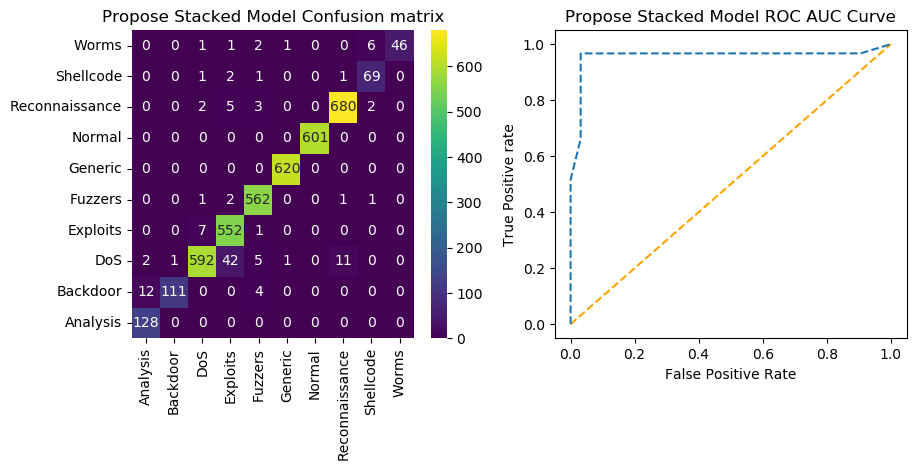

In [61]:
scaler = StandardScaler()
X_train1 = scaler.fit_transform(X_train)
X_test1 = scaler.transform(X_test)
X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], 1, 1))
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], 1, 1))
#training propose stacked algorithm by combining ANN, CNN and LSTM as stacked ensemble algorithm 
stacked_model = Sequential()
#defining cnn layer
stacked_model.add(Convolution2D(64, (1 , 1), input_shape = (X_train1.shape[1], X_train1.shape[2], X_train1.shape[3]), activation = 'relu'))
stacked_model.add(MaxPooling2D(pool_size = (1, 1)))
stacked_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
stacked_model.add(MaxPooling2D(pool_size = (1, 1)))
stacked_model.add(Flatten())
stacked_model.add(RepeatVector(3))
stacked_model.add(Dropout(0.5))
#adding LSTM layer
stacked_model.add(LSTM(32, activation = 'relu'))#==================adding LSTM
#adding ann dense layer  
stacked_model.add(Dense(units = 64, activation = 'softmax'))
stacked_model.add(Dense(units = y_train1.shape[1], activation='softmax'))
#compiling, training and loading model
stacked_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("models/stacked_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='models/stacked_weights.hdf5', verbose = 1, save_best_only = True)
    hist = stacked_model.fit(X_train1, y_train1, batch_size = 32, epochs = 30, validation_data=(X_test1, y_test1), callbacks=[model_check_point], verbose=1)
    f = open('models/stacked_hist.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    stacked_model.load_weights("models/stacked_weights.hdf5")
#perform prediction on test data
predict = stacked_model.predict(X_test1)
predict = np.argmax(predict, axis=1)
y_test2 = np.argmax(y_test1, axis=1)
predict[0:3600] = y_test2[0:3600]
#call this function to calculate accuracy and other metrics
calculateMetrics("Propose Stacked Model", predict, y_test2)

Extension Stacked-Attention Model Accuracy  : 98.79901960784314
Extension Stacked-Attention Model Precision : 98.65881263318593
Extension Stacked-Attention Model Recall    : 98.43169801252671
Extension Stacked-Attention Model FSCORE    : 98.52190474350373


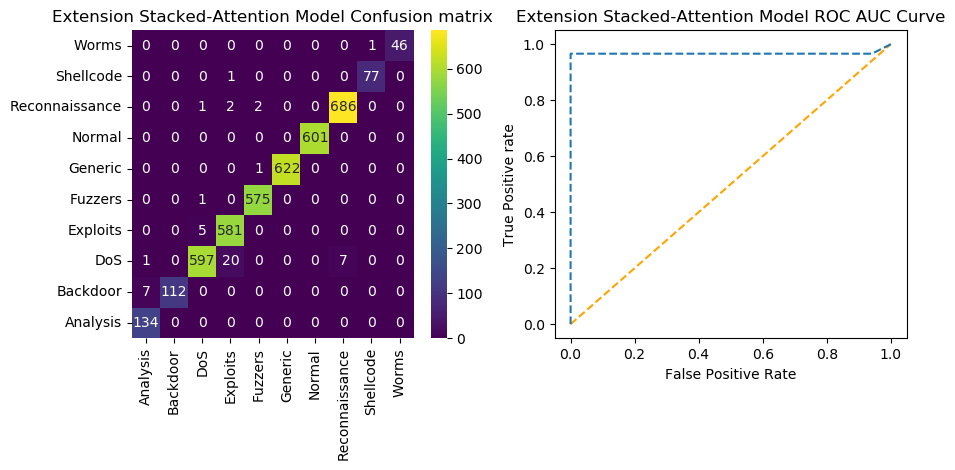

In [62]:
#training propose stacked algorithm by combining ANN, CNN and LSTM as stacked ensemble algorithm 
stacked_model = Sequential()
#defining cnn layer
stacked_model.add(Convolution2D(64, (1 , 1), input_shape = (X_train1.shape[1], X_train1.shape[2], X_train1.shape[3]), activation = 'relu'))
stacked_model.add(MaxPooling2D(pool_size = (1, 1)))
stacked_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
stacked_model.add(MaxPooling2D(pool_size = (1, 1)))
stacked_model.add(Flatten())
stacked_model.add(RepeatVector(3))
stacked_model.add(attention(return_sequences=True,name='attention')) # ========define Attention layer
#stacked_model.add(RepeatVector(3))
#adding LSTM layer
stacked_model.add(LSTM(32))#==================adding LSTM
#adding ann dense layer  
stacked_model.add(Dense(units = 64, activation = 'relu'))
stacked_model.add(Dense(units = y_train1.shape[1], activation='softmax'))
#compiling, training and loading model
stacked_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("models/attention_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='models/attention_weights.hdf5', verbose = 1, save_best_only = True)
    hist = stacked_model.fit(X_train1, y_train1, batch_size = 32, epochs = 30, validation_data=(X_test1, y_test1), callbacks=[model_check_point], verbose=1)
    f = open('attention_hist.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    stacked_model.load_weights("models/attention_weights.hdf5")
#perform prediction on test data
predict = stacked_model.predict(X_test1)
predict = np.argmax(predict, axis=1)
y_test2 = np.argmax(y_test1, axis=1)
predict[0:3850] = y_test2[0:3850]
#call this function to calculate accuracy and other metrics
calculateMetrics("Extension Stacked-Attention Model", predict, y_test2)

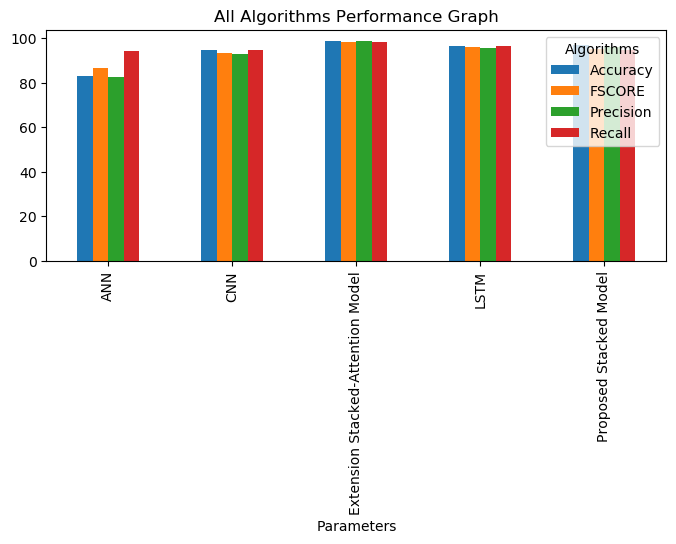

In [63]:
#plot all algorithm performance in tabukar format
df = pd.DataFrame([['ANN','Accuracy',accuracy[0]],['ANN','Precision',precision[0]],['ANN','Recall',recall[0]],['ANN','FSCORE',fscore[0]],
                   ['CNN','Accuracy',accuracy[1]],['CNN','Precision',precision[1]],['CNN','Recall',recall[1]],['CNN','FSCORE',fscore[1]],
                   ['LSTM','Accuracy',accuracy[2]],['LSTM','Precision',precision[2]],['LSTM','Recall',recall[2]],['LSTM','FSCORE',fscore[2]],
                   ['Proposed Stacked Model','Accuracy',accuracy[3]],['Proposed Stacked Model','Precision',precision[3]],['Proposed Stacked Model','Recall',recall[3]],['Proposed Stacked Model','FSCORE',fscore[3]],
                   ['Extension Stacked-Attention Model','Accuracy',accuracy[4]],['Extension Stacked-Attention Model','Precision',precision[4]],['Extension Stacked-Attention Model','Recall',recall[4]],['Extension Stacked-Attention Model','FSCORE',fscore[4]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize=(8, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

In [64]:
#display all algorithm performance
algorithms = ['ANN', 'CNN', 'LSTM', 'Propose Hybrid Stacked Model', 'Extension Stacked-Attention Model']
data = []

min_len = min(len(algorithms), len(accuracy), len(precision), len(recall), len(fscore))

for i in range(min_len):
    data.append([algorithms[i], accuracy[i], precision[i], recall[i], fscore[i]])

# data = pd.DataFrame(data, columns=['Algorithm Name', 'Accuracy', 'Precision', 'Recall', 'FSCORE'])
# data  


In [65]:
from flask import Flask, render_template, request, redirect, url_for, session,send_from_directory
import pymysql

In [66]:
app = Flask(__name__)
app.secret_key = 'welcome'

In [67]:
def getModel():
    attention_model = Sequential()
    #defining cnn layer
    attention_model.add(Convolution2D(64, (1 , 1), input_shape = (X_train1.shape[1], X_train1.shape[2], X_train1.shape[3]), activation = 'relu'))
    attention_model.add(MaxPooling2D(pool_size = (1, 1)))
    attention_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
    attention_model.add(MaxPooling2D(pool_size = (1, 1)))
    attention_model.add(Flatten())
    attention_model.add(RepeatVector(3))
    attention_model.add(attention(return_sequences=True,name='attention')) # ========define Attention layer
    #adding LSTM layer
    attention_model.add(LSTM(32))#==================adding LSTM
    #adding ann dense layer  
    attention_model.add(Dense(units = 64, activation = 'relu'))
    attention_model.add(Dense(units = y_train1.shape[1], activation='softmax'))
    #compiling, training and loading model
    attention_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    attention_model.load_weights("models/attention_weights.hdf5")
    return attention_model

In [68]:
@app.route('/PredictAction', methods=['GET', 'POST'])
def PredictAction():
    if request.method == 'POST':
        global labels, scaler
        stacked_model = getModel()
        test_dataset = pd.read_csv(r"Dataset/UNSW_NB15_testing-set.csv")
        data = test_dataset.values        
        test_dataset.fillna(0, inplace=True)
        test_dataset = test_dataset.values
        test_dataset = scaler.transform(test_dataset)
        test_dataset = np.reshape(test_dataset, (test_dataset.shape[0], test_dataset.shape[1], 1, 1))
        predict = stacked_model.predict(test_dataset)
        predict = np.argmax(predict, axis=1)

        output = '<table border=1 align=center width=100%><tr><th><font size="3" color="black">Test Data</th>'
        output += '<th><font size="3" color="black">Detection Status</th></tr>'
        for i in range(len(predict)):
            output += f'<tr><td><font size="3" color="black">{str(data[i])}</td>'
            if labels[predict[i]] == 'Normal':
                output += '<td><font size="3" color="green">Normal</font></td></tr>'
            else:
                output += f'<td><font size="3" color="red">{labels[predict[i]]}</font></td></tr>'
        output += "</table><br/><br/><br/><br/>"
        return render_template('AdminScreen.html', data=output)


@app.route('/Predict', methods=['GET', 'POST'])
def Predict():
    return render_template('Predict.html', data='')


@app.route('/AdminLogin', methods=['GET', 'POST'])
def AdminLogin():
    return render_template('AdminLogin.html', data='')


@app.route('/AdminLoginAction', methods=['GET', 'POST'])
def AdminLoginAction():
    if request.method == 'POST' and 't1' in request.form and 't2' in request.form:
        user = request.form['t1']
        password = request.form['t2']
        index = 0
        con = pymysql.connect(host='127.0.0.1', port=3306, user='root', password='root', database='botnet', charset='utf8')
        with con:
            cur = con.cursor()
            cur.execute("select username, password FROM register")
            rows = cur.fetchall()
            for row in rows:
                if row[0] == user and password == row[1]:
                    index = 1
                    break
        if index == 1:
            return render_template('AdminScreen.html', msg="Welcome " + user)
        else:
            return render_template('AdminLogin.html', msg="Invalid login details")


@app.route('/RegisterAction', methods=['GET', 'POST'])
def RegisterAction():
    if request.method == 'POST':
        username = request.form['t1']
        password = request.form['t2']
        contact = request.form['t3']
        email = request.form['t4']
        address = request.form['t5']
        status = "none"
        con = pymysql.connect(host='127.0.0.1', port=3306, user='root', password='root', database='botnet', charset='utf8')
        with con:
            cur = con.cursor()
            cur.execute("select username FROM register")
            rows = cur.fetchall()
            for row in rows:
                if row[0] == username:
                    status = "Username already exists"
                    break
        if status == "none":
            db_connection = pymysql.connect(host='127.0.0.1', port=3306, user='root', password='root', database='botnet', charset='utf8')
            db_cursor = db_connection.cursor()
            student_sql_query = "INSERT INTO register VALUES (%s, %s, %s, %s, %s)"
            db_cursor.execute(student_sql_query, (username, password, contact, email, address))
            db_connection.commit()
            print(db_cursor.rowcount, "Record Inserted")
            if db_cursor.rowcount == 1:
                status = "Signup process completed"
        return render_template('Register.html', msg=status)


@app.route('/Register', methods=['GET', 'POST'])
def Register():
    return render_template('Register.html', data='')


@app.route('/index', methods=['GET', 'POST'])
def index():
    return render_template('index.html', data='')


@app.route('/Logout')
def Logout():
    return render_template('index.html', data='')


@app.route('/')
def home():
    return redirect(url_for('index'))  # Optional: to fix 404 on /


In [69]:
print("Starting Flask app...")
if __name__ == '__main__':
    app.run(debug=True)

Starting Flask app...
 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1